# Probabilistic Programming for Cosmology with JAX
<a target="_blank" href="https://colab.research.google.com/github/hsimonfroy/talks/blob/main/2024CoPhy/ppl4cosmo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
# @title Install
# %pip install -q numpyro getdist
# %pip install -q git+https://github.com/DifferentiableUniverseInitiative/JaxPM.git
!hostname
!python -c "import jax; print(jax.default_backend())"

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.2' # NOTE: jax preallocates GPU (default 75%)
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from getdist import plots, MCSamples, gaussian_mixtures

from jax import numpy as jnp, random as jr, jit, grad, value_and_grad, hessian, vmap, tree, debug

import numpyro.distributions as dist
from numpyro import sample, deterministic, plate, infer, render_model
from numpyro.handlers import seed, condition, trace
from numpyro.infer.util import log_density

%matplotlib inline
%load_ext autoreload
%autoreload 2

feynmangpu04.cluster.local


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


gpu
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


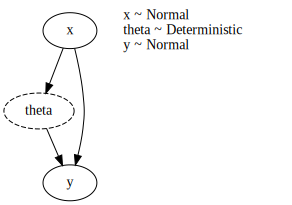

In [13]:
from numpyro import sample, deterministic, plate, render_model, param

def model():
    x = sample('x', dist.Normal(0, 1))
    theta = deterministic('theta',x)
    ###############
    # TODO: sample y from a Normal distribution with mean x**2 and std 1
    y = sample('y', dist.Normal(x**2, theta))
    ###############

    return y

render_model(model, render_distributions=True, render_params=True)

2024-12-13 22:08:54.340627: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


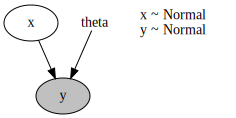

In [4]:
from numpyro.handlers import seed, condition, trace, substitute

# Handle random seeds for reproducibility
seeded_model = seed(model, 42)

# Sample from model
y_obs = dict(y=seeded_model())

# Condition model on variable
obs_model = substitute(model, y_obs)
obs_model = condition(model, y_obs)
render_model(obs_model, render_distributions=True, render_params=True)

In [5]:
seeded_model = seed(model, 42)
# seeded_model = substitute(seeded_model, {'y': 2.})
# seeded_model = condition(seeded_model, {'y': 3.})
trace(seeded_model).get_trace()

OrderedDict([('x',
              {'type': 'sample',
               'name': 'x',
               'fn': <numpyro.distributions.continuous.Normal at 0x7fffa007c8c0>,
               'args': (),
               'kwargs': {'rng_key': Array([255383827, 267815257], dtype=uint32),
                'sample_shape': ()},
               'value': Array(1.3694694, dtype=float32),
               'scale': None,
               'is_observed': False,
               'intermediates': [],
               'cond_indep_stack': [],
               'infer': {}}),
             ('theta',
              {'type': 'param',
               'name': 'theta',
               'fn': <function numpyro.util.identity(x, *args, **kwargs)>,
               'args': (3.0,),
               'kwargs': {},
               'value': 3.0,
               'scale': None,
               'cond_indep_stack': []}),
             ('y',
              {'type': 'sample',
               'name': 'y',
               'fn': <numpyro.distributions.continuous.Normal

In [6]:
from numpyro.infer.util import log_density

# Compute log probability of model
log_joint = lambda params: log_density(model,(),{},params)[0]
print(log_joint({'x': 0., 'y': 0., 'theta': 100.}))

-6.4430475


In [5]:
from dataclasses import dataclass
from numpyro.infer.util import log_density
from numpyro import handlers
from numpyro.infer.reparam import LocScaleReparam
from jax import tree


class Model():
    def _model(self):
        raise NotImplementedError
    
    def model(self):
        return self._model()

    def reset(self):
        self.model = self._model

    def __call__(self):
        return self.model()

    ############
    # Wrappers #
    ############
    def potential(self, params):
        return - log_density(self.model, (), {}, params)[0]
    
    def seed(self, rng=0):
        self.model = handlers.seed(self.model, rng_seed=rng)

    def trace(self, rng=0):
        return handlers.trace(handlers.seed(self.model, rng_seed=rng)).get_trace()
    
    def condition(self, data=None):
        self.model = handlers.condition(self.model, data=data or {})

    def block(self, hide=None, expose=None):
        self.model = handlers.block(self.model, hide=hide, expose=expose)

    def render(self):
        display(render_model(self.model, render_distributions=True, render_params=True))

    ############################

    def reparam(self, params_):
        return params_

    def __str__(self):
        return self.__dict__.__str__()
    
    def block_det(self, model, hide_base=True, hide_det=True):
        base_name = self.latent.keys()
        if hide_base:
            if hide_det:
                hide_fn = lambda site: site['type'] == 'deterministic'
            else:
                hide_fn = lambda site: site['type'] == 'deterministic' and site['name'] in base_name
        else:
            if hide_det:
                hide_fn = lambda site: site['type'] == 'deterministic' and site['name'] not in base_name
            else:
                hide_fn = lambda site: False
        return handlers.block(model, hide_fn=hide_fn)

    def predict(self, rng=0, samples=None, hide_base=True, hide_det=True, hide_samp=False):
        """
        Run model conditionned on samples.
        If samples is None, return a single prediction.
        If samples is an int, return a prediction of that length.
        If samples is a dict, return a prediction for each sample.
        """
        if isinstance(rng, int):
            rng = jr.key(rng)

        def single_prediction(rng, sample={}):
            model = handlers.condition(self.model, data=sample)
            if hide_samp:
                model = handlers.block(model, hide=sample.keys())
            model = self.block_det(model, hide_base=hide_base, hide_det=hide_det)

            tr = handlers.trace(handlers.seed(model, rng_seed=rng)).get_trace()
            return {k: v['value'] for k, v in tr.items()}

        if samples is None:
            return single_prediction(rng)
        if isinstance(samples, int):
            rng = jr.split(rng, samples)
            return vmap(single_prediction)(rng)
        else:
            # All samples should have the same first dimension
            n_samples = samples[next(iter(samples))].shape[0]
            rng = jr.split(rng, n_samples)
            return vmap(single_prediction)(rng, samples)

@dataclass
class MyModel(Model):
    std: float
    latent: dict = None
    mesh_shape: np.ndarray = None
    box_shape: np.ndarray = None

    def __post_init__(self):
        if self.latent is None: 
            self.latent = {}

    def _model(self):
        x = sample('x_', dist.Normal(0, self.std))
        x = deterministic('x', x)

        y_mean = deterministic('y_mean', self.hep(x))
        # y_mean = deterministic('y_mean2', self.hep(y_mean))
        y = sample('y', dist.Normal(y_mean, self.std))
        z = sample('z', dist.Normal(y, self.std))
        return z
    
    def hep(self, x):
        return self.std*x**2
    


model = MyModel(std=1, latent={'x': 0.})
# print(model.potential({'x': 0., 'y': 0.}), model.simulate(42))
model.condition()
model.seed(42)
print(model())
model.reset()
# model.condition({'x_': 0.})
# model.block(hide={'x_': 0.}.keys())
model.predict(0, 1, 1,0,1)
# model.simulate2(42, {'x_': 0.}, 0, 0)
# model.render()
model.seed(42)
model.model()

-0.6223022


Array(-0.6223022, dtype=float32)

In [37]:

from dataclasses import dataclass
from collections import UserDict
from jax import tree, tree_util


# @partial(tree_util.register_dataclass, data_fields=['data'], meta_fields=['groups']) # JAX >=0.4.27
@tree_util.register_pytree_node_class
@dataclass
class Sample(UserDict):
    """
    Global slicing and indexing s[1:3,2]
    Querying with groups s['abc', 'c', 'd'], s[['abc','c'],['d']]
    """
    data: dict
    groups: dict = None # dict of list of keys

    def __post_init__(self):
        if self.groups is None:
            self.groups = {}

    def __getitem__(self, key, default_fn=None):
        # Global indexing and slicing
        if self._istreeof(key, (int, slice)):
            return Sample(self.map(lambda x: x[key]), self.groups)

        # Querying with groups
        elif self._istreeof(key, str):
            if isinstance(key, str):
                if key in self.groups:
                    group = self.groups[key]
                    if len(group) == 1: # handle length 1 group
                        return self._get(group[0], default_fn)
                    else:
                        return tuple(self._get(k, default_fn) for k in group)
                    # return tuple(self._get(k, default_fn) for k in self.groups[key])
                else:
                    return self._get(key, default_fn)
                
            elif isinstance(key, list):
                return Sample({k:self._get(k, default_fn) for k in self._expand_key(key)}, self.groups)
            
            elif isinstance(key, tuple):
                return tuple(self.__getitem__(k, default_fn) for k in self._expand_key(key))
    
    def _expand_key(self, key):
        newkey = ()
        for k in key:
            if isinstance(k, str) and k in self.groups:
                newkey += tuple(self.groups[k])
            else:
                newkey += (k,)
        return newkey
    
    def _istreeof(self, obj, type):
        return tree.all(tree.map(lambda x: isinstance(x, type), obj))
    
    def _get(self, key, default_fn=None):
        """
        Rewrite dict get method to raise KeyError by default.
        """
        if key in self.data:
            return self.data[key]
        elif default_fn is not None:
            return default_fn(key)
        else:
            raise KeyError(key)

    def get(self, key, default=None, default_fn=None):
        return self.__getitem__(key, default_fn=(lambda k: default) if default_fn is None else default_fn)

    @property
    def shape(self):
        return tree.map(jnp.shape, self.data)
    
    # NOTE: no need with register_dataclass JAX >=0.4.27
    def tree_flatten(self):
        return (self.data,), self.groups
    
    @classmethod
    # NOTE: no need with register_dataclass JAX >=0.4.27
    def tree_unflatten(cls, groups, data):
        return cls(*data, groups)





data = dict(a=1, b=2, cz=3, dz=4)
# data = dict(a=np.ones((2,3)), b=np.ones((2,3)), c=np.ones((3,4)), d=np.ones((4,5)))
group = dict(abc=['a','b','cz'], dz=['dz'])    
s = Sample(data, group)

print(s[['abc','cz'],['dz']])
print(s['abc', 'cz', 'dz'])
print(s['abc'])
print(s[['abc']])
print(s['dz'])
print(s[['dz']])

# print(s[1:,2])
# print(s[1,0])
# s[['abc'],['c']]

(Sample(data={'a': 1, 'b': 2, 'cz': 3}, groups={'abc': ['a', 'b', 'cz'], 'dz': ['dz']}), Sample(data={'dz': 4}, groups={'abc': ['a', 'b', 'cz'], 'dz': ['dz']}))
(1, 2, 3, 3, 4)
(1, 2, 3)
Sample(data={'a': 1, 'b': 2, 'cz': 3}, groups={'abc': ['a', 'b', 'cz'], 'dz': ['dz']})
4
Sample(data={'dz': 4}, groups={'abc': ['a', 'b', 'cz'], 'dz': ['dz']})


In [364]:
def _istreeof(obj, type):
    print(tree.leaves(obj))
    return tree.all(tree.map(lambda x: isinstance(x, type), obj))
    # return tree.all(obj, is_leaf=lambda x: not isinstance(x, type))
    # return all(isinstance(i, type) for i in tree.leaves(obj))

_istreeof(('a',['a'], ('a', [slice(1,2)])), (str))

['a', 'a', 'a', slice(1, 2, None)]


False

In [329]:
tree.flatten((2,3,(4,5)))

([2, 3, 4, 5], PyTreeDef((*, *, (*, *))))

In [316]:
np.array([[1,2,3],[4,5,6]])[:,2]

array([3, 6])

In [ ]:
aa = (2,3)
aa = ('c','d')
def istupleof(obj, type):
    return isinstance(obj, tuple) and all(isinstance(i, type) for i in obj)

print(istupleof(aa, int))

True


In [ ]:
class MyClass:
    def method():
        return 'instance method called', 0

    @classmethod
    def classmethod(cls):
        return 'class method called', cls.method()

    @staticmethod
    def staticmethod():
        return 'static method called'
    
obj = MyClass()
# obj.method()
# MyClass.classmethod()
obj.classmethod()

('class method called', ('instance method called', 0))

In [ ]:
from numpyro.infer.util import log_density

# Compute log probability of model
log_joint = lambda params: log_density(model,(),{},params)[0]
print(log_joint({'x': 0., 'y': 0.}))

-1.837877
